In [36]:
import networkx as nx
import os
import json
import pandas as pd
import numpy as np
import momepy
import seaborn as sns
import shapely
import matplotlib.pyplot as plt
import tensorflow as tf

import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch.optim as optim
import torch.nn as nn
import torch

from torch_geometric.loader.dataloader import DataLoader
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data, Dataset
from sklearn import metrics
from torch_geometric.loader import ClusterData, ClusterLoader, NeighborSampler, NeighborLoader
from sklearn.preprocessing import StandardScaler

## 1. Data preparation

All graphs were obtained by integer linear programming solving transportation problem. 
  
Nodes represent houses and services (kindergartens), nodes attribute - type (house / service), coordinate (x, y) and initial resource value (demand for houses and capacity for services).    
Edges represent connection between house and service in view of population flow between them, edges attributes - population flow (or load), distance and value (True or False) describing whether the distance is less than normative (e.g. 300 m from house to kindergarten).

Graphs can be represented as either **sparse** graphs or **dense** graphs based on observed population flows.

In [2]:
def graph_to_gdf(graph):

    graph = nx.convert_node_labels_to_integers(graph, label_attribute="internal_id")
    nodes, edges = momepy.nx_to_gdf(graph, points=True, lines=True)
    nodes_geom = nodes.geometry
    edges["geometry"] = edges.apply(lambda x: shapely.geometry.LineString((nodes_geom[x.node_start], nodes_geom[x.node_end])), axis=1)

    return nodes, edges

In [4]:
graph = nx.read_graphml("./sparse_graphs/local/normative_2025_new.graphml", node_type=int)
graph_nodes, graph_edges = graph_to_gdf(graph)
graph_nodes.to_file("./geojson_examples/01_06/spares_graph_nodes_.geojson", driver="GeoJSON")
graph_edges.to_file("./geojson_examples/01_06/spares_graph_edges_.geojson", driver="GeoJSON")

/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/momepy/utils.py:411: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")
/var/essdata/IDU/venvs/common_venv/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### 1.1 Sparse graphs

Sparse graphs initially contain **only positive edges** - with population flow (load) > 0.  
**Some negative edges** are sampled to force NN recognize this type of edge as well. 

Negative edge sampling strategy:  
- The number of negative edges is equal to the number of positive edges scaled with multiplying factor.
- One half of the sampled edges consists of nearest edges and another half of random edges (most of which represent great distance).  
The sampling strategy is chosen to represent that demand distributes between nearest services not always equally.  
  
Sparse graphs include either  **all objects** (~20 000 houses and ~1 000 services) or **some objects** randomly selected.  

Link on folder with spare graph data: https://drive.google.com/drive/u/1/folders/1QRFU-LP8HMtOISmDP2R7yO1PlAYx4CBN

In [3]:
def draw_sparse_example(G, house_node):

    node = house_node
    sample = G.edge_subgraph(G.edges(node))
    sample_copy = sample.copy()
    node_type = sample.nodes[node]["type"]
    connected_nodes = [(u, d) for u, d in G.nodes(data=True) if d["type"] != node_type]

    null_nodes = [connected_nodes[i] for i in np.random.choice(range(len(connected_nodes)), len(sample.edges))]
    null_edges = [
        (node, end_node[0], {"load": 0, 'distance': np.random.choice(range(100, 10000))}) for end_node in null_nodes
        ]
    sample_copy.add_nodes_from(null_nodes)
    sample_copy.add_edges_from(null_edges)
    properties = {node: {j: d["distance"] for i, j, d in sample_copy.edges(data=True)}}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), facecolor=(1, 1, 1))

    ax1.set_title("Initial graph", size=16)
    nx.draw_networkx(
        sample_copy, 
        nodelist=list(sample.nodes()),
        edgelist=list(sample.edges()),
        with_labels=False, 
        node_size=100,
        linewidths=1.5,
        node_color=["green" if d["type"] == "house" else "steelblue" for u, d in sample.nodes(data=True)],
        pos=nx.kamada_kawai_layout(sample_copy, properties), ax=ax1)

    ax2.set_title("Graph with null edges", size=16)
    nx.draw_networkx(
        sample_copy, 
        with_labels=False, 
        node_size=100,
        linewidths = 1.5,
        edge_color = ["red" if d["load"] == 0 else "black" for u,v,d in sample_copy.edges(data=True)],
        node_color = ["green" if d["type"] == "house" else "steelblue" for u, d in sample_copy.nodes(data=True)],
        pos=nx.kamada_kawai_layout(sample_copy, properties), ax=ax2)

    for n in ["green", "steelblue"]:
        ax1.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
        ax2.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
    ax1.legend(loc="upper left")  
    ax2.legend(loc="upper left")

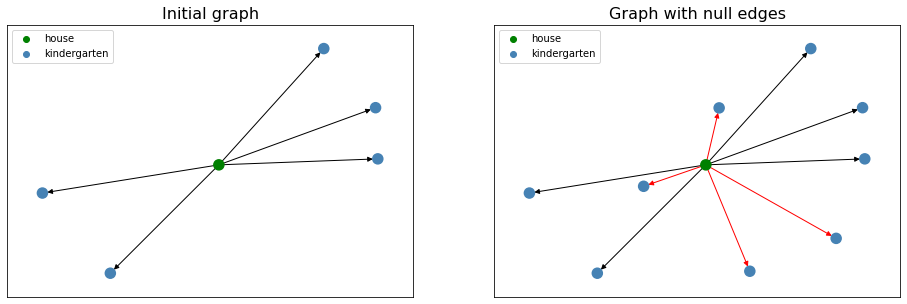

In [4]:
graph_example = nx.read_graphml("./sparse_graphs/full_city_model_demand_2022.graphml", node_type=int)

draw_sparse_example(graph_example, house_node=126600)
plt.show()

In [2]:
class ProvisionSparseDataset(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(ProvisionSparseDataset, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".graphml"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['../provision.dataset']

    def download(self):
        pass
    
    def process(self):

        null_edge_ratio = 4
        accessibility_normative = 300 

        # read distance matrix to build null edges with distance as weights
        matrix = pd.read_json(os.path.join(self.root, "distance_matrix.json"))

        data_list = []
        for file in self.raw_file_names:
            
            # read DIRECTED graph
            graph = nx.read_graphml(os.path.join(self.root, file), node_type=int)
            del graph.graph['node_default'], graph.graph['edge_default']
            
            for u, d in graph.nodes(data=True):
                obj_type = 1. if d["type"] == "house" else 0.
                initial_value = float(d["demand"]) if "demand" in d else float(d["capacity"])
                d.clear()
                d["x"] = [obj_type, initial_value]
                d["id"] = u

            for u, v, d in graph.edges(data=True):
                d["is_available"] = 1. if d["distance"] <= accessibility_normative else 0.
                d["y"] = d["load"]
                del d["load"]

            x = np.array([[i, d["x"][0], d["x"][1]] for i, d in graph.nodes(data=True)])
            edges = np.array([[u, v, d["y"], d["is_available"], d["distance"]] for u, v, d in graph.edges(data=True)])
            houses_id = x[:, 0][x[:, 1] == 1]
            services_id = x[:, 0][x[:, 1] == 0]

            # negative sampling - add random null edges to graph
            # the number of null edges is equal to len(edges) * null_edge_ratio
            null_edges = []
            for h_id in houses_id:
                connected_services = edges[:, 1][edges[:, 0] == h_id]
                remain_services = [s for s in services_id if s not in connected_services]
                distance = matrix[h_id][remain_services].sort_values()
                
                s_ids = []
                num_nearest_s = null_edge_ratio // 2
                num_random_s = null_edge_ratio - num_nearest_s

                s_ids.extend(list(distance.iloc[:num_nearest_s].index))
                remain_services = [s for s in remain_services if s not in s_ids]
                s_ids.extend(np.random.choice(remain_services, num_random_s, replace=False))
                distances = list(matrix[h_id][s_ids])
                null_edges.extend([(
                    h_id, s_id, {"y": 0., "is_available": 1. if d <= accessibility_normative else 0., "distance": d}
                 ) for s_id, d in zip(s_ids, distances)])

            graph.add_edges_from(null_edges)

            graph = pyg.utils.convert.from_networkx(graph, group_edge_attrs=["is_available", "distance"])
            graph.edge_attr = torch.tensor(graph.edge_attr.numpy(), dtype=torch.float32)

            # sort edge_index, edge_attr and y
            graph.edge_index, attr = pyg.utils.sort_edge_index(
                graph.edge_index, [graph.y, graph.edge_attr], graph.num_nodes, True
                )
            graph.y, graph.edge_attr = attr

            data_list.append(graph)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

In [3]:
sparse_dataset = ProvisionSparseDataset("./sparse_graphs/local")

### 1.2 Dense graphs

ISN'T USED IN THE CURRENT VERSION.

Dense graphs contain **ALL edges** (all positive and ALL negative), but include **a few objects** (~ 1 000 houses and ~ 100 services) since it's too expensive to train/test NN with huge dense graphs.

In [7]:
def draw_dense_example(G, house_node):

    node = house_node
    sample = G.edge_subgraph(G.edges(node))
    sample_copy = sample.copy()

    plt.figure(figsize=(8, 6))
    plt.title("Graph with null edges", size=16)
    nx.draw_networkx(
        sample_copy, 
        with_labels=False, 
        node_size=100,
        linewidths = 1.5,
        edge_color = ["red" if d["load"] == 0 else "black" for u,v,d in sample_copy.edges(data=True)],
        node_color = ["green" if d["type"] == "house" else "steelblue" for u, d in sample_copy.nodes(data=True)],
)
        
    for n in ["green", "steelblue"]:
        plt.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
    plt.legend(loc="upper left")

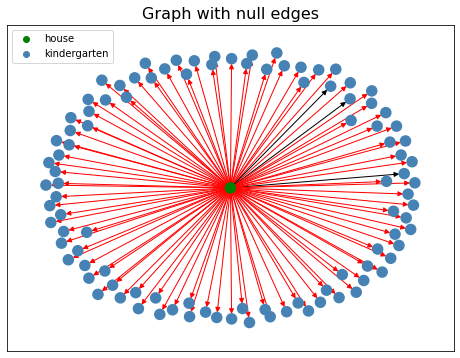

In [10]:
graph_example = nx.read_graphml("./dense_graphs/normarive_2030_greater_demand.graphml", node_type=int)

draw_dense_example(graph_example, house_node=114276)
plt.show()

In [4]:
class ProvisionDenseDataset(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(ProvisionDenseDataset, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".graphml"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['../provision.dataset']

    def download(self):
        pass
    
    def process(self):

        accessibility_normative = 300 

        data_list = []
        for file in self.raw_file_names:
            
            # read DIRECTED graph
            graph = nx.read_graphml(os.path.join(self.root, file), node_type=int)
            del graph.graph['node_default'], graph.graph['edge_default']
            
            for u, d in graph.nodes(data=True):
                obj_type = 1. if d["type"] == "house" else 0.
                initial_value = float(d["demand"]) if "demand" in d else float(d["capacity"])
                coord = [d["x"], d["y"]]
                d.clear()
                
                d["x"] = [obj_type, initial_value]
                d["id"] = u
                d["coord"] = coord

            for u, v, d in graph.edges(data=True):
                d["is_available"] = 1. if d["distance"] <= accessibility_normative else 0.
                d["y"] = d["load"]
                del d["load"]
            
            graph = pyg.utils.convert.from_networkx(graph, group_edge_attrs=["is_available", "distance"])
            graph.edge_attr = torch.tensor(graph.edge_attr.numpy(), dtype=torch.float32)

            # sort edge_index, edge_attr and y
            graph.edge_index, attr = pyg.utils.sort_edge_index(
                graph.edge_index, [graph.y, graph.edge_attr], graph.num_nodes, True
                )
            graph.y, graph.edge_attr = attr

            data_list.append(graph)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

In [70]:
dense_dataset = ProvisionDenseDataset("./dense_graphs")

## 2. Model training

### 2.1 NN stack

First, **GNNConv** learns representation of each node using:  
  
  - type of object (house - 1, service - 0) and object's initial value (demand for houses and capacity for services) as node's features (tensor's size N x 2);
  - in some experiments onehotencoding was used as node's features (either by itself, or with initial features (type and demand/capacity))
  - distance between house and service as edge weight (tensor's size N x 1).

GNN includes 2 hidden layers to get nodes' embeddings (N x 128). After each hidden layer Dropout (0.25) and Layer Normalization are applied.
  
To predict population flows based on nodes'representation:
  1. Concatenation of nodes' representation and distance between them is performed (N x 257). 
  2. **MLP** learns to predict population flow based on the vectors gained at the step 1.  
    
MLP includes 3 hidden layers and 1 output layer that returns population flows (N x 1).   
After the output layer, **normalization** is used to restrict the sum of population flow considering existing demand and capacity.  
The main idea of normalization at this step is to balance flows by proportional factors from origin's (houses) and destination's (services) initial value. 
  
$$
y_{norm_{i,j}} = min(  \frac{y_{i, j} * demand_{i}}{\sum_{j = 1}^{k}{y_{i, j}}}, \frac{y_{i, j} * capacity_{j}}{\sum_{i = 1}^{m}{y_{i, j}}}  )
$$

  
<p align="center">
  <img src="./img/normalization.png" />
</p>

Loss function - **MSE**, quality metrics - **R2, total error** (the total number of erroneously predicted people). 

In [29]:
torch.manual_seed(42)
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_conv_layers, dropout, aggr=None):
        super(GNNStack, self).__init__()

        self.aggr = "sum"

        self.lin = nn.ModuleList()
        self.lin.append(nn.Linear(input_dim, hidden_dim))
        for i in range(2 - 1):
            self.lin.append(nn.Linear(hidden_dim, hidden_dim))

        self.convs = nn.ModuleList()
        self.num_conv_layers = num_conv_layers
        self.convs.append(pyg_nn.GCNConv(input_dim, hidden_dim, aggr=self.aggr))
        for l in range(self.num_conv_layers - 1):
            self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim, aggr=self.aggr))

        self.norm = nn.ModuleList()
        for l in range(self.num_conv_layers):
            self.norm.append(nn.LayerNorm(hidden_dim))

        self.dropout = dropout
        self.a = torch.nn.Parameter(torch.rand(1)*3.4028e-38)
        self.b = torch.nn.Parameter(torch.tensor([1.]))


    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, self.a / (data.edge_attr[:, 1] + 1) ** self.b
        
        for i in range(self.num_conv_layers):
            x = self.convs[i](x, edge_index, edge_weight)
            emb = x
            x = nn.functional.leaky_relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.norm[i](x)
        
        return emb


class FlowPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(FlowPredictor, self).__init__()

        self.num_layers = num_layers

        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(self.num_layers - 2):
            self.lins.append(nn.Linear(hidden_dim, hidden_dim))
        self.lins.append(nn.Linear(hidden_dim, output_dim))

        self.lin_ = nn.Linear(hidden_dim + 3, hidden_dim)

        self.layer_norm = nn.ModuleList()
        for l in range(self.num_layers - 1):
            self.layer_norm.append(nn.LayerNorm(hidden_dim))

        self.dropout = dropout
        self.a = torch.nn.Parameter(torch.rand(1)*3.4028e-38)
        self.b = torch.nn.Parameter(torch.tensor([1.]))

    def normalize(self, x, edge_index, y):

        y = torch.exp(y)
        y_sum_i = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
        y_norm_i = y * x[:, 1][edge_index[0, :]] / (y_sum_i[edge_index[0]] + 3.4028e-38)
        y_sum_j = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y)
        y_norm_j = y * x[:, 1][edge_index[1, :]] / (y_sum_j[edge_index[1]] + 3.4028e-38)

        y_new = torch.min(y_norm_i, y_norm_j)
        return y_new

    def forward(self, emb, data):

        x, edge_index, edge_weight = data.x, data.edge_index, self.a / (data.edge_attr[:, 1] + 1) ** self.b
        emb_x_i = emb[edge_index[0]]
        emb_x_j = emb[edge_index[1]]
        coef = edge_weight.reshape(len(edge_weight), -1) 
        y = torch.cat((emb_x_i, emb_x_j, coef), axis=1)

        for i in range(self.num_layers - 1):
            y = self.lins[i](y) 
            y = nn.functional.leaky_relu(y)
            y = F.dropout(y, p=self.dropout, training=self.training)

        y = self.lins[-1](y)
        y = torch.relu(y).squeeze()
        y_norm = self.normalize(x, edge_index, y)  # normalize y based on house demand and kindergarten capacity
        return y_norm
        

### 2.2 Baseline: doubly-constrained gravity model

Doubly-constrained gravity model is considered as a baseline.

$$
y_{norm_{i,j}} = \frac{demand_{i} * capacity_{j}}{d^{b}}, where
$$
 
*d* - distance measured on the road graph (distance decay function - power law).  
*b* - scaling factor fitted by MSE (b=0.78).

Origin's and destination's constraints for "in" and "out" flows are implemented in the same way as in neural network model:
$$
y_{norm_{i,j}} = min(  \frac{y_{i, j} * demand_{i}}{\sum_{j = 1}^{k}{y_{i, j}}}, \frac{y_{i, j} * capacity_{j}}{\sum_{i = 1}^{m}{y_{i, j}}}  )
$$

In [5]:
class GravityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = torch.nn.Parameter(torch.rand(1) * 3.4028e-38) # learnable parameter which takes into account the impact of distance

    def normalize(self, x, edge_index, y):

        y_sum_i = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
        y_norm_i = y * x[:, 1][edge_index[0, :]] / (y_sum_i[edge_index[0]] + 3.4028e-38)

        y_sum_j = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y)
        y_norm_j = y * x[:, 1][edge_index[1, :]] / (y_sum_j[edge_index[1]] + 3.4028e-38)

        return torch.min(y_norm_i, y_norm_j)
    
    def forward(self, data):

        demand = data.x[:, 1][data.edge_index[0]]
        capacity = data.x[:, 1][data.edge_index[1]]
        distance = data.edge_attr[:, 1] + 1
        y = demand * capacity / distance ** self.b
        y_norm = self.normalize(data.x, data.edge_index, y)
        return y_norm

### 2.3 Train, Validate and Test

For training and validation we use sparse graphs.
The graphs in sparse_dataset are randomly divided into a **training sample** and a **validation sample** without replacement (**out-of-sample forecast** strategy is applied).  
Optimization algorithm - Adam, learning rate - 0.001, weight_decay=0.001.

Testing is performed on the very dense full city graph where each house node is connected to all services nodes. The aim is to define flow for each edge (either 0 or > 0).  
Testing graph include ~27 million edges. To process such an amount of edges, testing is performed iteratively. On each iteration only edges with cirtain distances are considered (e.g. edges with distance between 300 and 600 m).

Link on test_data: https://drive.google.com/drive/u/1/folders/1eUjwpeY344NkqgvAXbWBNtk78dP93zNv

In [30]:
def train(epochs, train_dataset, valid_dataset, test_data, writer, model, checkpoints=None):
    
    torch.manual_seed(0)
    input_dim_conv = 2
    hidden_dim_conv = 128 
    output_dim_conv = 128
    num_conv_layers = 2

    link_hidden_dim = 129
    link_output_dim = 1
    num_linear_layer = 4
    

    dropout = 0.25

    # learn network structure
    # train_loader = DataLoader([one_hot_encode(data, 22741) for data in train_dataset])
    # valid_loader = DataLoader([one_hot_encode(data, 22741) for data in valid_dataset])

    train_loader = DataLoader([data for data in train_dataset])
    valid_loader = DataLoader([data for data in valid_dataset])

    # build model
    if model == "NN":
        emb_model = GNNStack(input_dim_conv, hidden_dim_conv, output_dim_conv, num_conv_layers, dropout)
        flow_model = FlowPredictor(2 * output_dim_conv + 1, link_hidden_dim, link_output_dim, num_linear_layer, dropout)
        params = list(emb_model.parameters()) + list(flow_model.parameters())
        optimize = optim.Adam(params,  lr=0.001, weight_decay=0.001)
        # torch.autograd.set_detect_anomaly(True)

    else:
        gravity_model = GravityModel()
        params = list(gravity_model.parameters())
        optimize = optim.Adam(list(gravity_model.parameters()),  lr=0.001)
        gravity_model.train()

    # train
    for epoch in range(epochs + 1):

        train_loss = []
        train_r2 = []
        for train_data in train_loader:
            optimize.zero_grad()

            # train NN model
            if model == "NN":

                # resume training if checkpoints were specified
                if checkpoints:
                    checkpoint = torch.load(checkpoints)
                    emb_model.load_state_dict(checkpoint['emb_model'])
                    flow_model.load_state_dict(checkpoint['flow_model'])
                    optimize.load_state_dict(checkpoint['optimizer'])

                emb_model.train()
                flow_model.train()

                embedding = emb_model(train_data)
                predict_y = flow_model(embedding, train_data)
                loss_function = torch.nn.MSELoss(reduction="mean")


            # 'train' gravity model to find coefficients based on observed data   
            else:
                gravity_model.train()
                predict_y = gravity_model(train_data)
                loss_function = torch.nn.MSELoss(reduction="sum")
                
            loss = loss_function(predict_y, train_data.y)
            train_loss.append(loss)
            train_r2.append(r2_loss(predict_y, train_data.y))

            loss.backward()
            optimize.step()
                
        train_r2 = sum(train_r2) / len(train_r2)
        train_loss = sum(train_loss) / len(train_loss)
        writer.add_scalar("train_loss", train_loss, epoch)
        writer.add_scalar("train_r2", train_r2, epoch)

        model_stack = [emb_model, flow_model] if model == "NN" else [gravity_model]

        if epoch % 5 == 0:
            v_metrics = validate(valid_loader, model, model_stack)
            print(
                "Epoch {}. TRAIN: loss {:.4f}, r2: {:.4f}.".format(epoch, train_loss, train_r2) + \
                "VALIDATION loss: {:.4f}, standard deviation {:.4f}, r2: {:.4f}, total error {:.4f}."\
                .format(v_metrics["valid_loss"], v_metrics["valid_std"], v_metrics["valid_r2"], v_metrics["valid_total_error"])
            )
            for name, v_metrics in v_metrics.items():
                writer.add_scalar(name, v_metrics, epoch)

        if epoch % 50 == 0:
            t_metrics = test(test_data, model, model_stack)
            print(
                "\nEpoch {}. TEST loss: {:.4f}, standard deviation {:.4f}, r2: {:.4f}, total error {:.4f}.\n"\
                .format(epoch, t_metrics["test_loss"], t_metrics["test_std"], t_metrics["test_r2"], t_metrics["test_total_error"])
            )
            
            for name, t_metrics in t_metrics.items():
                writer.add_scalar(name, t_metrics, epoch)
    
    # save checkpoint to resume training later
    if model == "NN":
        save_ckp(epoch, emb_model, flow_model, optimize, f_path="./model")

    return model_stack


def validate(valid_loader, model, model_stack):

    if model == "NN":
        emb_model, flow_model = model_stack
        emb_model.eval()
        flow_model.eval()
    else:
        gravity_model = model_stack[0]
        gravity_model.eval()

    test_loss = []
    test_r2 = []
    test_total_error = []
    test_std = []
    for test_data in valid_loader:
        with torch.no_grad():

            if model == "NN":
                embedding = emb_model(test_data)
                predict_y = flow_model(embedding, test_data)
            else:
                predict_y = gravity_model(test_data)

            true_y = test_data.y
            test_loss.append(F.mse_loss(predict_y, test_data.y))
            test_r2.append(r2_loss(predict_y, true_y))
            test_total_error.append(torch.sum(torch.abs(true_y - predict_y)))
            test_std.append(torch.std(torch.abs(true_y - predict_y)))
    return {
        "valid_loss": np.mean(test_loss), "valid_r2": np.mean(test_r2), 
        "valid_total_error": np.mean(test_total_error), "valid_std": np.mean(test_std)
        }


def one_hot_encode(data, max_nodes):

    emb = torch.nn.functional.one_hot(torch.tensor([i for i in range(data.num_nodes)]))
    nodes_features = torch.cat((data.x, emb), axis=1)

    if data.num_nodes != max_nodes:
        zeros = torch.zeros(data.num_nodes, max_nodes - data.num_nodes)
        nodes_features = torch.cat((nodes_features, zeros), axis=1)
    
    new_data = data.clone()
    new_data.x = nodes_features
    return new_data


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2


def save_ckp(epoch, emb_model, flow_model, optimizer, f_path):
    checkpoint = {
    'epoch': epoch + 1,
    'emb_model': emb_model.state_dict(),
    'flow_model': flow_model.state_dict(),
    'optimizer': optimizer.state_dict()
}
    f_path = os.path.join(f_path, 'checkpoint.pt')
    torch.save(checkpoint, f_path)

In [48]:
def test(graph, model, model_stack, response="stat"):

    max_dist = torch.max(graph.edge_attr).item()
    steps = [0]
    d = 300
    while d < max_dist:
        steps.append(d)
        d *= 2

    graph.id_edge = torch.tensor(range(graph.num_edges), dtype=torch.long)
    data_bunch = Data(
        x=graph.x.clone(), 
        edge_index=torch.tensor([[],[]], dtype=torch.long), 
        edge_attr=torch.tensor([]),
        id_edge = torch.tensor([], dtype=torch.long)
        )
    # data_bunch = one_hot_encode(data_bunch, 22741)

    predict_y = torch.zeros_like(graph.y)
    id_edge = torch.tensor([])
    for n in range(len(steps)-1): 

        # on each step we select edges for which the following statements are True:
        # 1. distance less than d,
        # 2. source and target have resources (capacity and demand),
        # 3. population  flow wasn't predicted on the previous step.
        
        select = (graph.edge_attr[:, 1] >= steps[n]) &\
                 (graph.edge_attr[:, 1] <= steps[n+1]) &\
                 (((data_bunch.x[:, 1][graph.edge_index[0]] != 0) &\
                 (data_bunch.x[:, 1][graph.edge_index[1]] != 0)) &\
                 (predict_y == 0))
        
        data_bunch.edge_index = graph.edge_index[:, select]
        data_bunch.edge_attr = graph.edge_attr[select]
        data_bunch.y = graph.y[select]
        data_bunch.id_edge = graph.id_edge[select]

        with torch.no_grad():

            if model == "NN":
                emb_model, flow_model = model_stack
                emb = emb_model(data_bunch)
                y = flow_model(emb, data_bunch)

            else:
                gravity_model = model_stack[0]
                y = gravity_model(data_bunch)
                
        y = torch.floor(y)

        print(f"For edge with distance less than {n} R2:", r2_loss(y, data_bunch.y))
        demand_limit = torch.zeros_like(data_bunch.x[:, 1], dtype=y.dtype).index_add_(0, data_bunch.edge_index[0], y)
        capacity_limit = torch.zeros_like(data_bunch.x[:, 1], dtype=y.dtype).index_add_(0, data_bunch.edge_index[1], y)
        data_bunch.x[:, 1] = torch.round(data_bunch.x[:, 1] - capacity_limit - demand_limit)

        predict_y = predict_y.index_add_(0, data_bunch.id_edge, y)
        id_edge = torch.cat((id_edge, data_bunch.id_edge))
    
    test_loss = F.mse_loss(predict_y, graph.y)
    test_r2 = r2_loss(predict_y, graph.y)
    test_total_error = torch.sum(torch.abs(graph.y - predict_y))
    test_std = torch.std(torch.abs(graph.y - predict_y))
    
    if response == "stat":
        return {
            "test_loss": test_loss, "test_r2": test_r2, "test_total_error": test_total_error, "test_std": test_std
            }
    elif response == "y":
        return predict_y

In [6]:
sparse_dataset = sparse_dataset.shuffle()
train_dataset = sparse_dataset[:1]
validate_dataset = sparse_dataset[1:]
test_data = torch.load("./test_data/normative_2025_new.pt")

print("Train dataset:\n", train_dataset[0])
print("\nValidate datasets:")
for dataset in validate_dataset:
    print(dataset)
print("\nTest data:\n", test_data)

Train dataset:
 Data(x=[22738, 2], edge_index=[2, 107594], y=[107594], id=[22738], edge_attr=[107594, 2])

Validate datasets:
Data(x=[22741, 2], edge_index=[2, 107592], y=[107592], id=[22741], edge_attr=[107592, 2])

Test data:
 Data(x=[22741, 2], edge_index=[2, 27429714], edge_attr=[27429714, 2], y=[27429714], id=[22741])


In [33]:
from tensorboardX import SummaryWriter
from datetime import datetime
logdir = "./logs/18_01_23/" + "gravity_model-" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [32]:
writer = SummaryWriter(logdir)
file_writer = tf.summary.create_file_writer(logdir)

my_text = """Node features - demand/capacity.
Edge prediction by concatenation nodes' emmbedings and distance coef.
Stack: GCN (leaky_relu) -> LayerNorm -> VNN (leaky_relu) -> doubly-constrained normalization.
Aggr function - sum. Loss function - MSELoss sum."""
with file_writer.as_default():
  tf.summary.text("description", my_text, step=0)


emb_model, flow_model = train(2000, train_dataset[:1], validate_dataset[:1], test_data, writer, model="NN")

Epoch 0. TRAIN: loss 62.4757, r2: 0.0822.VALIDATION loss: 62.3910, standard deviation 7.1835, r2: 0.0838, total error 353406.8125.

Epoch 0. TEST loss: 0.1429, standard deviation 0.3779, r2: 0.5081, total error 200702.0000.

Epoch 5. TRAIN: loss 61.9743, r2: 0.0896.VALIDATION loss: 61.4221, standard deviation 7.0887, r2: 0.0981, total error 359643.3750.
Epoch 10. TRAIN: loss 61.1201, r2: 0.1022.VALIDATION loss: 59.6509, standard deviation 6.9140, r2: 0.1241, total error 370341.3438.
Epoch 15. TRAIN: loss 60.3985, r2: 0.1128.VALIDATION loss: 58.8557, standard deviation 6.8374, r2: 0.1358, total error 374355.1250.
Epoch 20. TRAIN: loss 60.3264, r2: 0.1138.VALIDATION loss: 58.7163, standard deviation 6.8262, r2: 0.1378, total error 374558.8125.
Epoch 25. TRAIN: loss 59.7547, r2: 0.1222.VALIDATION loss: 57.9754, standard deviation 6.7579, r2: 0.1487, total error 377442.0000.
Epoch 30. TRAIN: loss 59.3557, r2: 0.1281.VALIDATION loss: 57.6138, standard deviation 6.7337, r2: 0.1540, total err

In [34]:
writer = SummaryWriter(logdir)

gravity_model = train(3000, train_dataset, validate_dataset, test_data, writer, model="gravity_model")[0]

Epoch 0. TRAIN: loss 6018111.5000, r2: 0.1783.VALIDATION loss: 55.9123, standard deviation 6.5539, r2: 0.1790, total error 387320.5938.

Epoch 0. TEST loss: 0.1076, standard deviation 0.3279, r2: 0.6295, total error 181747.0000.

Epoch 5. TRAIN: loss 5990642.0000, r2: 0.1821.VALIDATION loss: 55.6578, standard deviation 6.5393, r2: 0.1827, total error 386370.9375.
Epoch 10. TRAIN: loss 5963396.0000, r2: 0.1858.VALIDATION loss: 55.4055, standard deviation 6.5248, r2: 0.1864, total error 385419.8438.
Epoch 15. TRAIN: loss 5936410.5000, r2: 0.1895.VALIDATION loss: 55.1555, standard deviation 6.5105, r2: 0.1901, total error 384468.5000.
Epoch 20. TRAIN: loss 5909710.5000, r2: 0.1931.VALIDATION loss: 54.9081, standard deviation 6.4963, r2: 0.1937, total error 383517.6875.
Epoch 25. TRAIN: loss 5883287.0000, r2: 0.1968.VALIDATION loss: 54.6633, standard deviation 6.4823, r2: 0.1973, total error 382567.9375.
Epoch 30. TRAIN: loss 5857162.5000, r2: 0.2003.VALIDATION loss: 54.4213, standard devi

In [39]:
nn_ = []
gravity_ = []
true_y = []
for data in sparse_dataset:
    with torch.no_grad():
        true_y.append(data.y)

        emb = emb_model(data)
        link = data.edge_index
        nn_.append(torch.round(flow_model(emb, data)))
        gravity_.append(torch.round(gravity_model(data)))


def draw_error_plot(nn_errors, gravity_errors):

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(30,6))
    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True, linewidth=0.1)

    ax0.set_title("Errors distribution for test dataset 1", size=14)
    ax0.hist(gravity_errors[0], color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors[0]))})', **kwargs)
    ax0.hist(nn_errors[0], color="green", label=f'NN (max error - {max(np.abs(nn_errors[0]))})', **kwargs)
    ax0.legend()

    ax1.set_title("Errors distribution for test dataset 2", size=14)

    ax1.hist(gravity_errors[1], color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors[1]))})', **kwargs)
    ax1.hist(nn_errors[1], color="green", label=f'NN (max error - {max(np.abs(nn_errors[1]))})', **kwargs)
    ax1.legend()


    df_gravity = pd.DataFrame(
        [[val, f"Dataset {i + 1}", "Gravity"] for i in range(2) for val in gravity_errors[i]], 
        columns=["value", "dataset", "model"]
        )
    df_nn = pd.DataFrame(
        [[val, f"Dataset {i + 1}", "NN"] for i in range(2) for val in nn_errors[i]], 
        columns=["value", "dataset", "model"]
        )
    data_df = pd.concat([df_gravity, df_nn])
    sns.boxplot(data=data_df, x="dataset", y="value", hue="model", palette="Spectral")
    
    plt.show()

### Errors distribution for positive edges

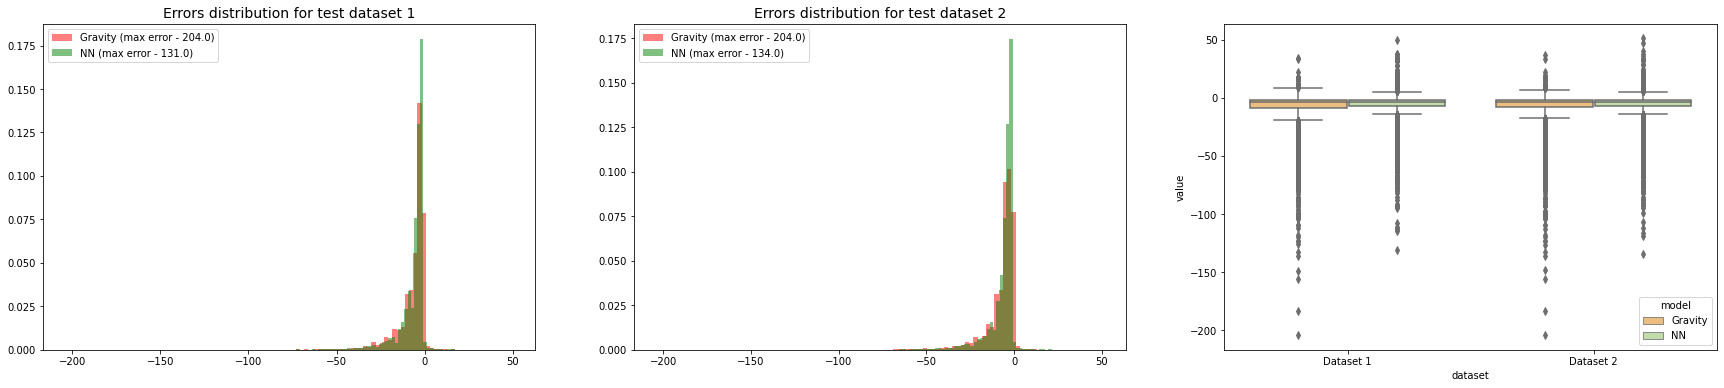

In [41]:
nn_errors = []
gravity_errors = []
for i, y in enumerate(true_y):
    pos_edges = y > 0
    nn_errors.append((nn_[i][pos_edges] - y[pos_edges]).tolist())
    gravity_errors.append((gravity_[i][pos_edges] - y[pos_edges]).tolist())

draw_error_plot(nn_errors, gravity_errors)

### Errors distribution for negative (zero) edges

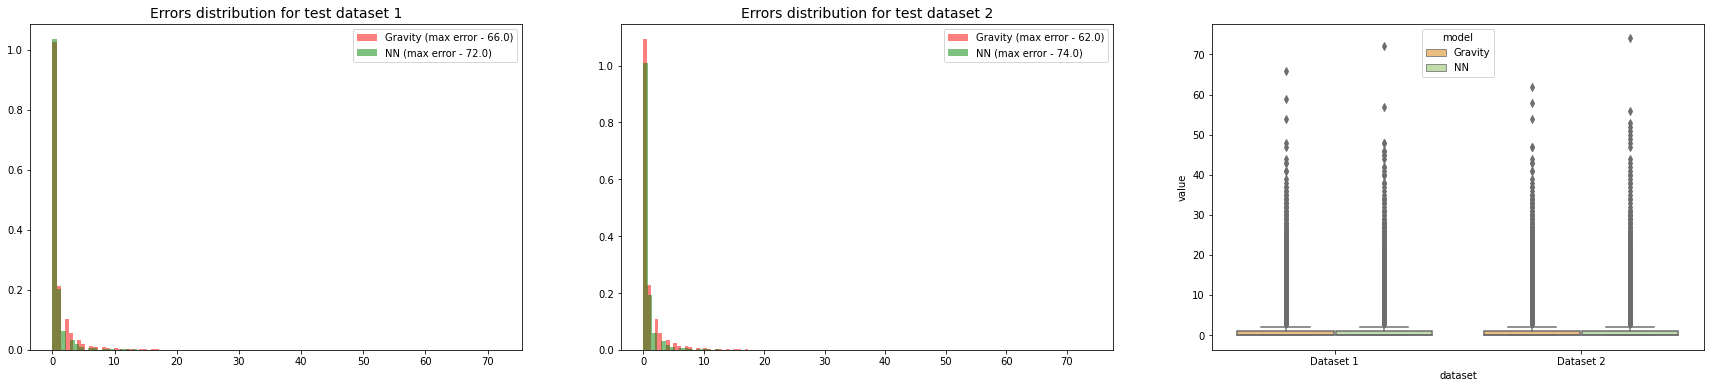

In [42]:
nn_errors = []
gravity_errors = []
for i, y in enumerate(true_y):
    pos_edges = y == 0
    nn_errors.append((nn_[i][pos_edges] - y[pos_edges]).tolist())
    gravity_errors.append((gravity_[i][pos_edges] - y[pos_edges]).tolist())

draw_error_plot(nn_errors, gravity_errors)

### Pivot table

In [66]:
with torch.no_grad():
    pos_edges = test_data.y > 0
    
    print("-------- GNN + MLP ---------")
    nn_predict_y = test(test_data, "NN", [emb_model, flow_model], response="y")
    nn_errors = (torch.round(nn_predict_y[pos_edges]) - test_data.y[pos_edges]).tolist()

    print("-------- Gravity model ---------")
    gravity_predict_y = test(test_data, "gravity_model", [gravity_model], response="y")
    gravity_errors = (torch.round(gravity_predict_y[pos_edges]) -test_data.y[pos_edges]).tolist()

-------- GNN + MLP ---------
For edge with distance less than 0 R2: tensor(0.8418)
For edge with distance less than 1 R2: tensor(0.5751)
For edge with distance less than 2 R2: tensor(0.2739)
For edge with distance less than 3 R2: tensor(0.0942)
For edge with distance less than 4 R2: tensor(0.1604)
For edge with distance less than 5 R2: tensor(-0.0008)
For edge with distance less than 6 R2: tensor(0.0372)
For edge with distance less than 7 R2: tensor(-2.5034e-06)
For edge with distance less than 8 R2: tensor(-1.9789e-05)
-------- Gravity model ---------
For edge with distance less than 0 R2: tensor(0.7626)
For edge with distance less than 1 R2: tensor(0.5054)
For edge with distance less than 2 R2: tensor(0.3440)
For edge with distance less than 3 R2: tensor(0.2135)
For edge with distance less than 4 R2: tensor(0.1780)
For edge with distance less than 5 R2: tensor(0.0473)
For edge with distance less than 6 R2: tensor(0.0713)
For edge with distance less than 7 R2: tensor(-0.0406)
For edge

In [51]:
pd.DataFrame({
    "r2 score": [r2_loss(nn_predict_y, test_data.y).item(), r2_loss(gravity_predict_y, test_data.y).item()],
    "absolute total error": [
        (torch.sum(torch.abs(test_data.y - nn_predict_y))).item(), 
        (torch.sum(torch.abs(test_data.y - gravity_predict_y))).item()
        ],
    "mean error": [
        torch.mean(torch.abs(test_data.y[test_data.y !=0] - nn_predict_y[test_data.y !=0])).item(), 
        torch.mean(torch.abs(test_data.y[test_data.y !=0] - gravity_predict_y[test_data.y !=0])).item(),
        ],
    "errors std": [
        torch.std(torch.abs(test_data.y[test_data.y !=0] - nn_predict_y[test_data.y !=0])).item(), 
        torch.std(torch.abs(test_data.y[test_data.y !=0] - gravity_predict_y[test_data.y !=0])).item()
        ]
}, index=["Neural network", "Gravity Model"])

,r2 score,absolute total error,mean error,errors std
Neural network,0.652089,166925.0,5.171029,8.687499
Gravity Model,0.623102,192955.0,5.420627,8.999018


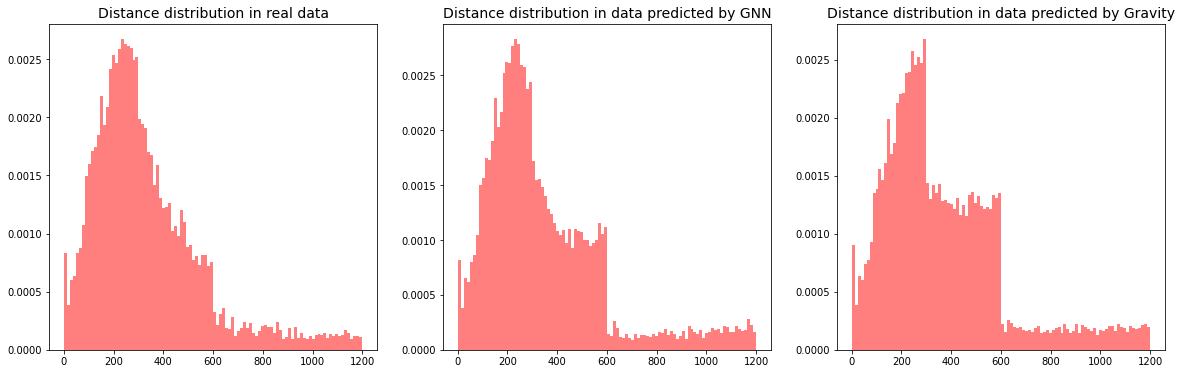

In [58]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,6))
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True, linewidth=0.1)

dist_select  = test_data.edge_attr[:, 1] <= 1200
dist = test_data.edge_attr[:, 1][dist_select]
y = test_data.y[dist_select]
nn_y = nn_predict_y[dist_select]
gravity_y = gravity_predict_y[dist_select]

ax0.set_title("Distance distribution in real data", size=14)
ax0.hist(dist, color="red", weights=y, **kwargs)
ax1.set_title("Distance distribution in data predicted by GNN", size=14)
ax1.hist(dist, color="red", weights=nn_y, **kwargs)
ax2.set_title("Distance distribution in data predicted by Gravity", size=14)
ax2.hist(dist, color="red", weights=gravity_y, **kwargs)

plt.show()

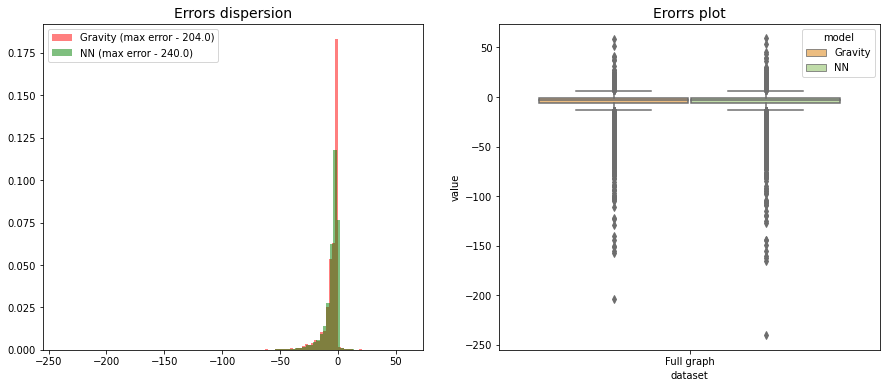

In [61]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,6))
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True, linewidth=0.1)

ax0.set_title("Errors dispersion", size=14)
ax0.hist(gravity_errors, color="red", label=f'Gravity (max error - {max(np.abs(gravity_errors))})', **kwargs)
ax0.hist(nn_errors, color="green", label=f'NN (max error - {max(np.abs(nn_errors))})', **kwargs)
ax0.legend()

df_gravity = pd.DataFrame(
    [[val, f"Full graph", "Gravity"] for val in gravity_errors], 
    columns=["value", "dataset", "model"]
    )
df_nn = pd.DataFrame(
    [[val, f"Full graph", "NN"] for val in nn_errors], 
    columns=["value", "dataset", "model"]
    )

data_df = pd.concat([df_gravity, df_nn])
ax1.set_title('Erorrs plot', size=14)
sns.boxplot(data=data_df, x="dataset", y="value", hue="model", palette="Spectral")

plt.show()

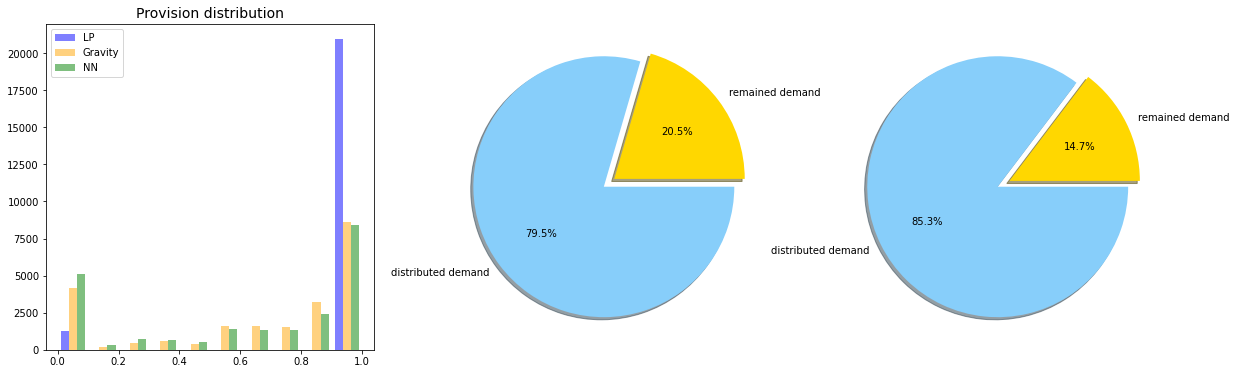

In [63]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,6))

select = (test_data.x[:, 1]) > 0 & (test_data.x[:, 0] == 1)

zero = torch.zeros_like(test_data.x[:, 1], dtype=test_data.y.dtype)
nn_y_sum = zero.index_add_(0, test_data.edge_index[0], nn_predict_y)
df_nn = pd.DataFrame(nn_y_sum[select] / test_data.x[:, 1][select], columns=["provision"])
df_nn["model"] = "NN"

zero = torch.zeros_like(test_data.x[:, 1], dtype=test_data.y.dtype)
gravity_y_sum = zero.index_add_(0, test_data.edge_index[0], gravity_predict_y)
gravity_df = pd.DataFrame(torch.round(gravity_y_sum[select]) / test_data.x[:, 1][select], columns=["provision"])
gravity_df["model"] = "Gravity"

zero = torch.zeros_like(test_data.x[:, 1], dtype=test_data.y.dtype)
true_y_sum= zero.index_add_(0, test_data.edge_index[0], test_data.y)
true_df = pd.DataFrame(torch.round(true_y_sum[select]) / test_data.x[:, 1][select], columns=["provision"])
true_df["model"] = "True"

ax0.set_title("Provision distribution", size=14)
ax0.hist(
    (true_df["provision"], gravity_df["provision"], df_nn["provision"]), 
    label = ["LP", "Gravity", "NN"],
    color=["blue", "orange", "green"], 
    alpha=0.5)
ax0.legend()

ax1.pie(
    [torch.sum(test_data.y) - torch.sum(nn_predict_y), torch.sum(nn_predict_y)],
    explode=[0.1, 0],
    labels = ["remained demand", "distributed demand"],
    colors = ['gold', 'lightskyblue'],
    autopct='%1.1f%%',
    shadow=True)

ax2.pie(
    [torch.sum(test_data.y) - torch.sum(gravity_predict_y), torch.sum(gravity_predict_y)],
    explode=[0.1, 0],
    labels = ["remained demand", "distributed demand"],
    colors = ['gold', 'lightskyblue'],
    autopct='%1.1f%%',
    shadow=True)
plt.show()